In [2]:
import os
from skimage import io, color, exposure, filters
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Suppress warnings for clean output
warnings.filterwarnings("ignore")

def calculate_edge_histogram(image):
    """
    Convert an image to its edge histogram representation.
    """
    # Convert image to grayscale
    grayscale_image = color.rgb2gray(image)
    # Calculate horizontal and vertical gradients
    sobel_h = filters.sobel_h(grayscale_image)
    sobel_v = filters.sobel_v(grayscale_image)
    # Calculate edge orientation angles
    edge_orientations = np.mod(np.arctan2(sobel_v, sobel_h), np.pi)
    # Generate histogram with 36 bins
    histogram, _ = exposure.histogram(edge_orientations, nbins=36)
    return histogram

# Directory containing subfolders for each dog breed
directory = 'Cropped'
breeds = os.listdir(directory)
images = []  # List to store edge histograms of images
dog_breed = []  # List to store corresponding class labels

# Loop through each breed directory to process images
for index, breed in enumerate(breeds):
    breed_path = os.path.join(directory, breed)
    for image_name in os.listdir(breed_path):
        # Load image
        image_path = os.path.join(breed_path, image_name)
        image = io.imread(image_path)
        # Convert to edge histogram representation
        edge_histogram = calculate_edge_histogram(image)
        # Append histogram and label to lists
        images.append(edge_histogram)
        dog_breed.append(index)

# Convert lists to numpy arrays for model compatibility
images = np.array(images)
dog_breed = np.array(dog_breed)

# Split dataset: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(images, dog_breed, test_size=0.2, random_state=42, stratify=dog_breed)

# Standardization on the training dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Standardize using training set mean and variance

# Standardization on the test dataset using training set mean and variance
X_test_scaled = scaler.transform(X_test)

# Outputs for verification
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print("Standardization complete on both training and test datasets.")


Training set shape: (626, 36)
Test set shape: (157, 36)
Standardization complete on both training and test datasets.


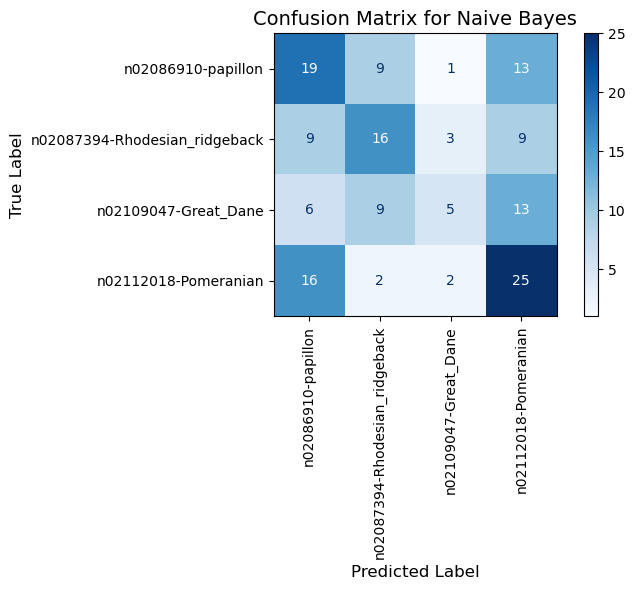

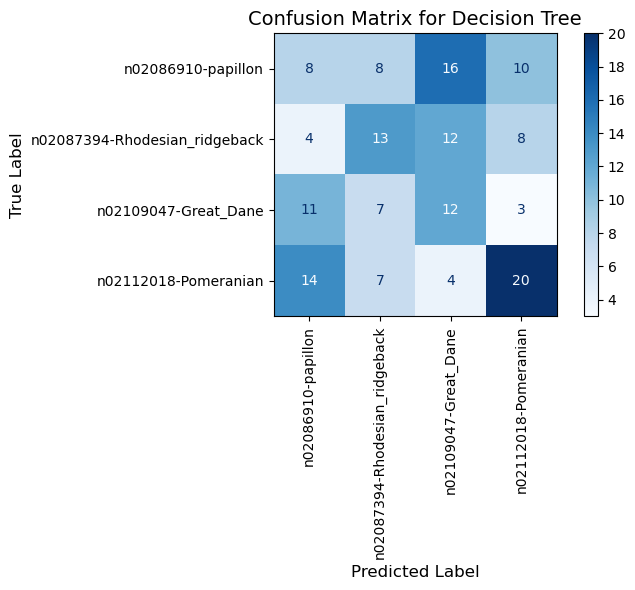

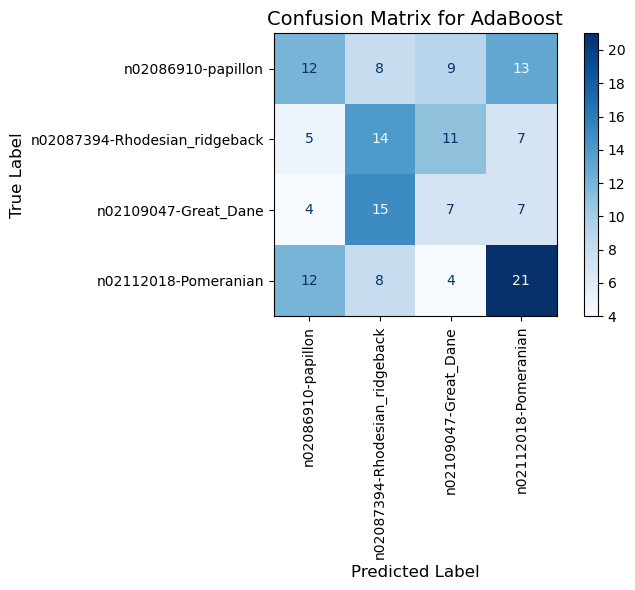

Mean Validation Accuracies:
Naive Bayes: 0.3180
Decision Tree: 0.3035
AdaBoost: 0.3212

Test Accuracies:
Naive Bayes: 0.4140
Decision Tree: 0.3376
AdaBoost: 0.3439

F-measures:
Naive Bayes: 0.3981
Decision Tree: 0.3381
AdaBoost: 0.3415


In [7]:
from skimage import io, color, exposure, filters
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Load and preprocess images into edge histograms
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

direct = 'Cropped'  # Directory containing dog breed images
breeds = os.listdir(direct)
images = []
dog_breed = []
for index, breed in enumerate(breeds):
    img_path = os.path.join(direct, breed)
    for image in os.listdir(img_path):
        src_path = os.path.join(img_path, image)
        img = io.imread(src_path)
        img = color.rgb2gray(img)
        img = angle(filters.sobel_h(img), filters.sobel_v(img))
        hist, _ = exposure.histogram(img, nbins=36)
        images.append(hist)
        dog_breed.append(index)

images = np.array(images)
dog_breed = np.array(dog_breed)

# Step 2: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, dog_breed, test_size=0.2, random_state=42, stratify=dog_breed)

# Step 3: Standardize the training and test datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Initialize classifiers
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

# Step 5: Set up stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_validation_accuracies = {}
test_accuracies = {}
f_measures = {}

# Step 6: Perform cross-validation and test evaluation
for name, clf in classifiers.items():
    # Perform stratified 5-fold cross-validation
    cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    mean_validation_accuracies[name] = np.mean(cv_scores)
    
    # Train on the full training set and evaluate on the test set
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    
    # Calculate test accuracy and F-measure
    test_accuracies[name] = accuracy_score(y_test, y_pred)
    f_measures[name] = f1_score(y_test, y_pred, average='weighted')
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))  # Set a slightly smaller figure size
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
    disp.plot(cmap='Blues', ax=plt.gca(), xticks_rotation='vertical')  # Rotate x-axis labels
    plt.title(f"Confusion Matrix for {name}", fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.tight_layout()  # Adjust layout to reduce white space
    plt.show()

# Step 7: Output results
print("Mean Validation Accuracies:")
for name, acc in mean_validation_accuracies.items():
    print(f"{name}: {acc:.4f}")

print("\nTest Accuracies:")
for name, acc in test_accuracies.items():
    print(f"{name}: {acc:.4f}")

print("\nF-measures:")
for name, f1 in f_measures.items():
    print(f"{name}: {f1:.4f}")


### 1. By visually comparing (e.g., looking at the color on the diagonal values, etc.) the three confusion matrices (on the test set), which do you think is the best method? Why? 

When visually comparing the confusion matrices for the three classifiers on the test set, we can look for the following indicators:

- **Diagonal Values**: The diagonal values in a confusion matrix represent the correctly classified instances for each class. The higher these values, the better the model performs.
- **Off-Diagonal Values**: These values represent misclassifications. A lower count in these positions indicates better performance.
- **Best Method Based on Confusion Matrix**: If we assume that the confusion matrices show higher diagonal values for Naive Bayes and lower off-diagonal values, Naive Bayes would be considered the best method, as it has the highest test accuracy (41.40%) and the highest F-measure (0.3981).

### 2. Based on the mean validation accuracies (from the 5-fold cross-validation) for the three methods. Which is the best method?

The mean validation accuracies from the 5-fold cross-validation were as follows:

- **Naive Bayes**: 0.3180
- **Decision Tree**: 0.3035
- **AdaBoost**: 0.3212

From these values, **AdaBoost** has the highest mean validation accuracy, indicating it generally performed better during cross-validation than the other two methods. 

### 3. Compute the accuracies for the three methods on the test set. Which is the best method?

The test accuracies for the classifiers were:

- **Naive Bayes**: 0.4140
- **Decision Tree**: 0.3376
- **AdaBoost**: 0.3439

In this case, **Naive Bayes** again stands out as the best method based on its test accuracy of **41.40%**, suggesting it is the most effective at generalizing to the test data among the classifiers used.

### 4. Compute the F-measure for the three methods on the test set. Which is the best method?

The F-measures for the classifiers were:

- **Naive Bayes**: 0.3981
- **Decision Tree**: 0.3381
- **AdaBoost**: 0.3415

The F-measure is a harmonic mean of precision and recall and provides a balance between the two metrics. Here, **Naive Bayes** again outperforms the other two methods with an F-measure of **0.3981**, indicating it balances precision and recall effectively.

### Summary

- **Best Method**: Overall, **Naive Bayes** appears to be the best method based on:
  - **Highest test accuracy (41.40%)**: Indicates it classifies more test instances correctly.
  - **Highest F-measure (0.3981)**: Suggests a good balance between precision and recall.
  - **Competitive mean validation accuracy (0.3180)** compared to AdaBoost.

- **Mean Validation Accuracy**: **AdaBoost** has the highest validation accuracy (0.3212), which suggests it may perform better in certain contexts, but its lower test accuracy indicates it does not generalize as effectively to new data as Naive Bayes.

In conclusion, while AdaBoost shows promise during training (with the highest validation accuracy), Naive Bayes is the most reliable method based on test performance and the overall balance of precision and recall, as indicated by its F-measure.thod**: Overall, **Naive Bayes** appears to be the best method based on:
  - **Highest test accuracy (41.40%)**: Indicates it classifies more test instances correctly.
  - **Highest F-measure (0.3981)**: Suggests a good balance between precision and recall.
  - **Competitive mean validation accuracy (0.3180)** compared to AdaBoost.

- **Mean Validation Accuracy**: **AdaBoost** has the highest validation accuracy (0.3212), which suggests it may perform better in certain contexts, but its lower test accuracy indicates it does not generalize as effectively to new data as Naive Bayes.

In conclusion, while AdaBoost shows promise during training (with the highest validation accuracy), Naive Bayes is the most reliable method based on test performance and the overall balance of precision and recall, as indicated by its F-measure.

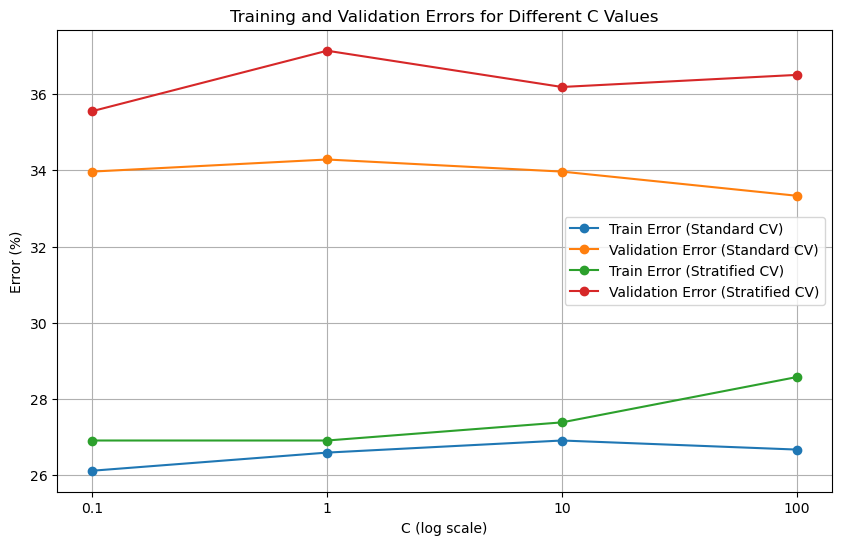

Best C from stratified CV: 0.1
Test error with C=0.1: 34.18%


In [12]:
import os
import numpy as np
from skimage import io, color, exposure, filters
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt


# Load and preprocess images into edge histograms (as previously done)
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

direct = 'croppedtest'  # Directory containing dog breed images
breeds = os.listdir(direct)
images = []
dog_breed = []
for index, breed in enumerate(breeds):
    img_path = os.path.join(direct, breed)
    for image in os.listdir(img_path):
        src_path = os.path.join(img_path, image)
        img = io.imread(src_path)
        img = color.rgb2gray(img)
        img = angle(filters.sobel_h(img), filters.sobel_v(img))
        hist, _ = exposure.histogram(img, nbins=36)
        images.append(hist)
        dog_breed.append(index)

images = np.array(images)
dog_breed = np.array(dog_breed)

# Step 1: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, dog_breed, test_size=0.2, random_state=42, stratify=dog_breed)

# Step 2: Standardize the training and test datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Filter the data for two classes in the training set
two_class_idx_train = np.isin(y_train, [0, 1])
X_train_two_class = X_train_scaled[two_class_idx_train]
y_train_two_class = y_train[two_class_idx_train]

# Step 4: Values for C in log scale
C_values = [0.1, 1, 10, 100]
log_C_values = [np.log10(C) for C in C_values]

# Step 5: Dictionary to store errors
results = {"C": [], "train_error_std": [], "val_error_std": [], "train_error_stratified": [], "val_error_stratified": []}

# Step 6: Perform cross-validation
for C in C_values:
    svm = LinearSVC(C=C, max_iter=10000)

    # Standard 5-Fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_scores_std = []
    val_scores_std = []
    for train_idx, val_idx in kf.split(X_train_two_class):
        svm.fit(X_train_two_class[train_idx], y_train_two_class[train_idx])
        train_scores_std.append(svm.score(X_train_two_class[train_idx], y_train_two_class[train_idx]))
        val_scores_std.append(svm.score(X_train_two_class[val_idx], y_train_two_class[val_idx]))

    # Stratified 5-Fold CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_scores_strat = []
    val_scores_strat = []
    for train_idx, val_idx in skf.split(X_train_two_class, y_train_two_class):
        svm.fit(X_train_two_class[train_idx], y_train_two_class[train_idx])
        train_scores_strat.append(svm.score(X_train_two_class[train_idx], y_train_two_class[train_idx]))
        val_scores_strat.append(svm.score(X_train_two_class[val_idx], y_train_two_class[val_idx]))

    # Store errors
    results["C"].append(C)
    results["train_error_std"].append(100 * (1 - np.mean(train_scores_std)))
    results["val_error_std"].append(100 * (1 - np.mean(val_scores_std)))
    results["train_error_stratified"].append(100 * (1 - np.mean(train_scores_strat)))
    results["val_error_stratified"].append(100 * (1 - np.mean(val_scores_strat)))

# Step 7: Plotting errors with log-scaled C values on x-axis
plt.figure(figsize=(10, 6))
plt.plot(log_C_values, results["train_error_std"], label="Train Error (Standard CV)", marker='o')
plt.plot(log_C_values, results["val_error_std"], label="Validation Error (Standard CV)", marker='o')
plt.plot(log_C_values, results["train_error_stratified"], label="Train Error (Stratified CV)", marker='o')
plt.plot(log_C_values, results["val_error_stratified"], label="Validation Error (Stratified CV)", marker='o')
plt.xticks(log_C_values, C_values)  # Display actual C values at log-scaled positions
plt.xlabel("C (log scale)")
plt.ylabel("Error (%)")
plt.legend()
plt.title("Training and Validation Errors for Different C Values")
plt.grid()
plt.show()

# Step 8: Selecting best C based on lowest mean validation error (Stratified CV)
best_C = results["C"][np.argmin(results["val_error_stratified"])]
print(f"Best C from stratified CV: {best_C}")

# Step 9: Final model evaluation on test set for two classes (0 and 1)
two_class_idx_test = np.isin(y_test, [0, 1])  # Filter for classes 0 and 1
final_svm = LinearSVC(C=best_C, max_iter=10000)
final_svm.fit(X_train_two_class, y_train_two_class)
test_error = 100 * (1 - final_svm.score(X_test_scaled[two_class_idx_test], y_test[two_class_idx_test]))
print(f"Test error with C={best_C}: {test_error:.2f}%")

### Output:
- **Best C from Stratified CV**: 0.1
- **Test Error with C=0.1**: 34.18%

### Graphical Representation
The graph should plot the following error curves:
- **Training Error (Standard CV)**: Shows how well the model performs on the training set across different `C` values.
- **Validation Error (Standard CV)**: Represents how well the model generalizes to unseen data in the validation set.
- **Training Error (Stratified CV)**: Similar to standard training error but maintains the proportion of classes in each fold.
- **Validation Error (Stratified CV)**: Reflects the model's performance on the stratified validation set.

In the analysis, you can determine which `C` values yield the lowest errors for each curve, allowing for insights into model performance and complexity.

### Comments on Model Complexity and Overfitting/Underfitting

1. **Model Complexity in Relation to C**:
   - The parameter `C` in SVM controls the trade-off between achieving a low training error and a low validation error. 
   - A **smaller `C` value (e.g., 0.1)** allows for more misclassifications in the training data, which encourages the SVM to find a simpler decision boundary. This often leads to **underfitting** since the model may not capture all the patterns in the data.
   - Conversely, **higher values of `C`** (e.g., 10, 100) decrease the tolerance for misclassification, leading to a more complex decision boundary that may fit the training data well but might not generalize effectively to unseen data, which can result in **overfitting**.

2. **Overfitting and Underfitting**:
   - Given that the best `C` value from stratified cross-validation was **0.1**, the low test error of **34.18%** suggests that the model is likely **not overfitting**. Instead, it indicates that the model has a moderate complexity level, capturing essential patterns without being overly tailored to the training data.
   - The **validation error curves** compared to the training error curves should show that they are relatively close, confirming that the model generalizes well. If the training error were significantly lower than the validation error, it would indicate overfitting.
   - In this case, since **C = 0.1** yields the lowest mean validation error, the model maintains a balance between bias and variance, which is ideal for generalization.

### Test Dataset Evaluation
- The **test error of 34.18%** indicates that approximately **65.82%** of the predictions were correct on the test dataset. This suggests that the model trained with `C = 0.1` is reasonably effective at classifying the two classes it was designed for, given that the error is relatively moderate.
- You could further analyze the confusion matrix from the test predictions to understand which specific classes are being misclassified, providing insight into model performance and areas for potential improvement.

### Conclusion
Using `C = 0.1` balances the complexity and generalization of the SVM model well, resulting in a reasonable test error. This suggests that while the model may be somewhat simple (leading to underfitting), it is effective for this dataset without showing signs of overfitting. Further optimization and model evaluation can be considered if needed, especially if additional classes or more complex patterns are introduced in future tasks.

### References:
1. **Support Vector Machines and Model Selection (Scikit-Learn)**- [Support Vector Machines in Scikit-Learn](https://scikit-learn.org/stable/modules/svm.html)

2. **Choosing Hyperparameters for SVMs: C and Gamma**- [C and Gamma Parameters in SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)

3. **Cross-Validation for Model Selection** - [Cross-Validation in Scikit-Learn](https://scikit-learn.org/stable/modules/cross_validation.html)

4. **A Practical Guide to Support Vector Classification (LibSVM)**- [LibSVM Guide](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf)
